# Pong - Problem Analysis and EDA

## Problem Analysis

In [26]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)
env = gym.make('ALE/Pong-v5')

print("Observation space:")
print(env.observation_space.shape)
print("\nAction space:")
print(env.action_space)

Observation space:
(210, 160, 3)

Action space:
Discrete(6)


In [5]:
%run src/collect_eda_data.py

Creating dataset at: /Users/jollyjerr/code/@school/pong/data/eda.h5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:52<00:00, 58.58s/it]

Done.


## EDA

Dataset shape:
<KeysViewHDF5 ['actions', 'episode_boundaries', 'observations', 'rewards', 'terminated', 'truncated']>

Total number of frames collected: 4362
Total number of episodes collected: 5

Minimum episode length: 783
Maximum episode length: 1000
Mean episode length: 872.40
Median episode length: 843.0
Standard deviation of episode lengths: 76.22


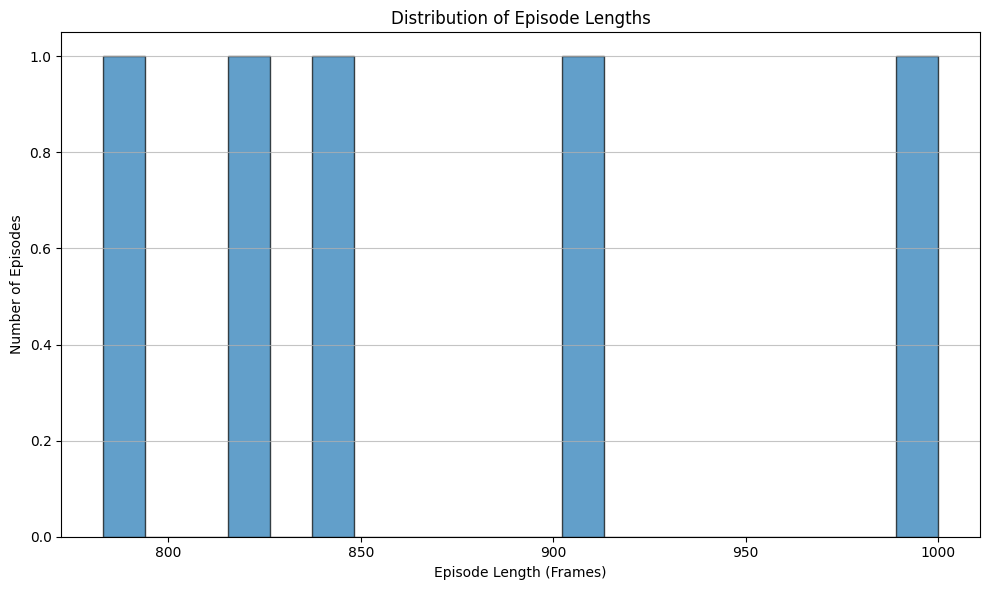

In [34]:
import h5py
import os 
import numpy as np
import matplotlib.pyplot as plt

file_path = os.path.join(os.getcwd(), 'data/eda.h5')

with h5py.File(file_path, 'r') as f:
    print("Dataset shape:")
    print(f.keys())

    total_frames = f['observations'].shape[0]
    print(f"\nTotal number of frames collected: {total_frames}")

    episode_boundaries = f['episode_boundaries'][:]
    num_episodes = episode_boundaries.shape[0]
    print(f"Total number of episodes collected: {num_episodes}")

    episode_lengths = []
    for start_idx, end_idx in episode_boundaries:
        episode_lengths.append(end_idx - start_idx + 1)

print(f"\nMinimum episode length: {np.min(episode_lengths)}")
print(f"Maximum episode length: {np.max(episode_lengths)}")
print(f"Mean episode length: {np.mean(episode_lengths):.2f}")
print(f"Median episode length: {np.median(episode_lengths)}")
print(f"Standard deviation of episode lengths: {np.std(episode_lengths):.2f}")

plt.figure(figsize=(10, 6))
plt.hist(episode_lengths, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Episode Lengths')
plt.xlabel('Episode Length (Frames)')
plt.ylabel('Number of Episodes')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


--- Cumulative Rewards Statistics ---
Minimum cumulative reward: -21.00
Maximum cumulative reward: -19.00
Mean cumulative reward: -20.40
Median cumulative reward: -21.00
Standard deviation of cumulative rewards: 0.80


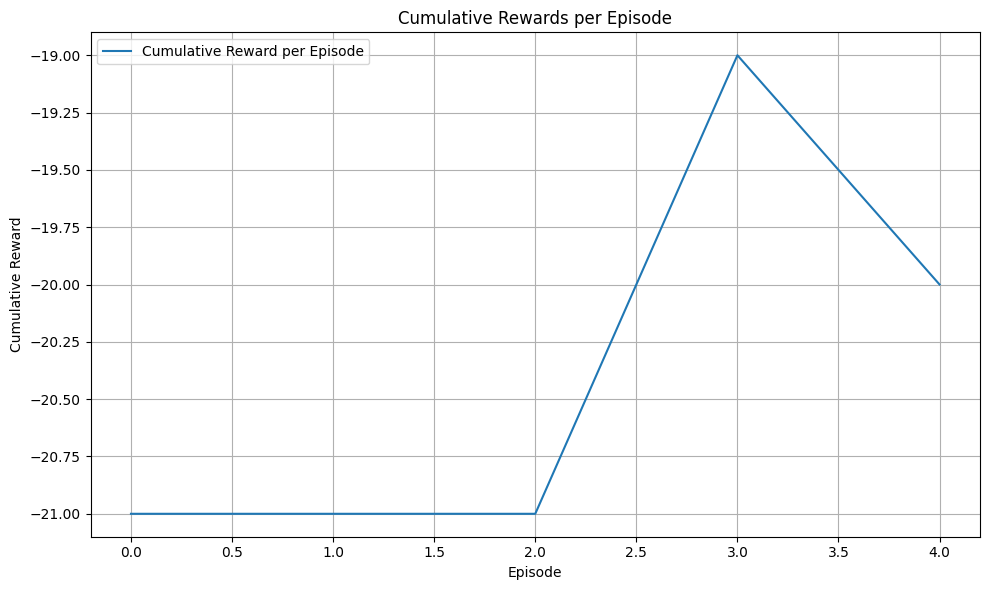

In [32]:
with h5py.File(file_path, 'r') as f:
    rewards_data = f['rewards'][:]
    episode_boundaries = f['episode_boundaries'][:]
    cumulative_rewards_per_episode = []

    for i, (start_idx, end_idx) in enumerate(episode_boundaries):
        episode_rewards = rewards_data[start_idx : end_idx + 1]
        cumulative_reward = np.sum(episode_rewards)
        cumulative_rewards_per_episode.append(cumulative_reward)

print("\n--- Cumulative Rewards Statistics ---")
print(f"Minimum cumulative reward: {np.min(cumulative_rewards_per_episode):.2f}")
print(f"Maximum cumulative reward: {np.max(cumulative_rewards_per_episode):.2f}")
print(f"Mean cumulative reward: {np.mean(cumulative_rewards_per_episode):.2f}")
print(f"Median cumulative reward: {np.median(cumulative_rewards_per_episode):.2f}")
print(f"Standard deviation of cumulative rewards: {np.std(cumulative_rewards_per_episode):.2f}")

plt.figure(figsize=(10, 6))
plt.plot(cumulative_rewards_per_episode, label='Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards per Episode')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

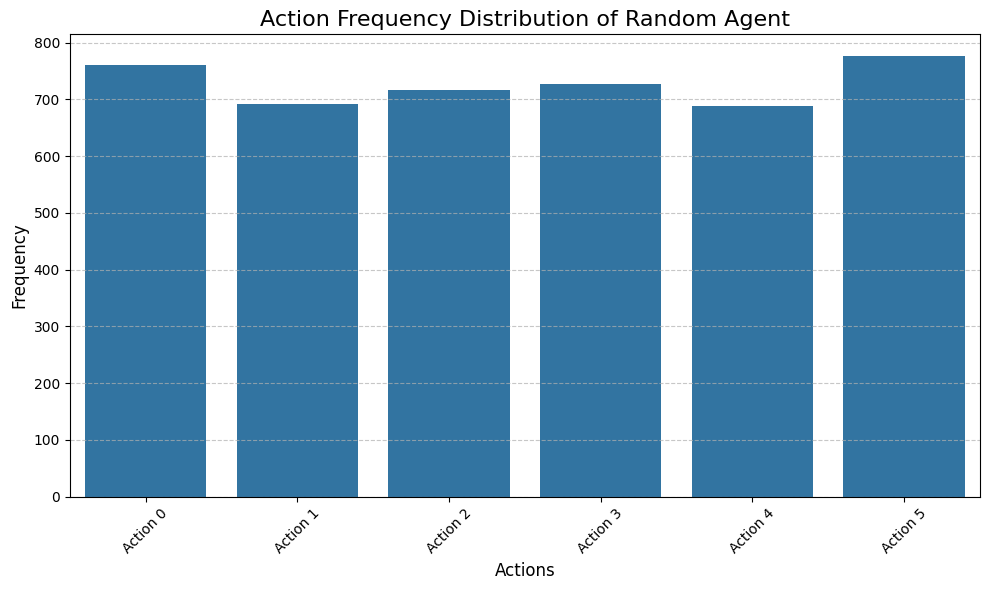

In [38]:
import seaborn as sns

action_names = [f"Action {i}" for i in range(env.action_space.n)]
with h5py.File(file_path, 'r') as f:
    actions = f['actions'][:]

unique, counts = np.unique(actions, return_counts=True)
action_freq = dict(zip(unique, counts))
full_freq = {i: action_freq.get(i, 0) for i in range(env.action_space.n)}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(full_freq.keys()), y=list(full_freq.values()))
plt.xticks(ticks=range(env.action_space.n), labels=action_names, rotation=45)
plt.title("Action Frequency Distribution of Random Agent", fontsize=16)
plt.xlabel("Actions", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


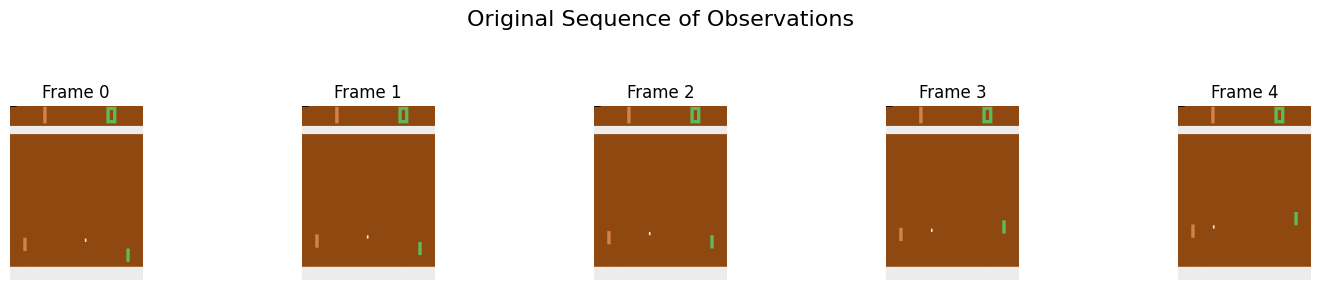

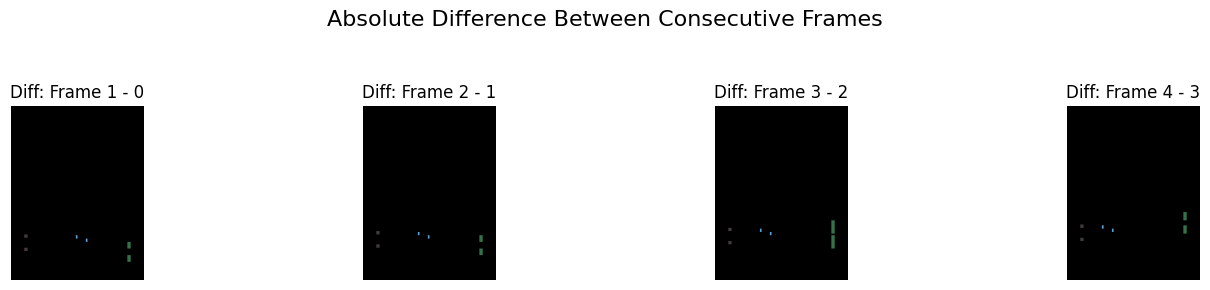

In [39]:
with h5py.File(file_path, 'r') as f:
    sample_episode_idx = 0
    sequence_start_idx = 100
    num_frames_to_show = 5

    frames = f['observations'][sequence_start_idx:sequence_start_idx + num_frames_to_show]
    
    diff_images = []
    for i in range(1, len(frames)):
        diff = np.abs(frames[i].astype(np.float32) - frames[i-1].astype(np.float32))
        diff = np.clip(diff, 0, 255).astype(np.uint8)
        diff_images.append(diff)

fig1, axes1 = plt.subplots(1, num_frames_to_show, figsize=(15, 3))
for i in range(num_frames_to_show):
    axes1[i].imshow(frames[i])
    axes1[i].set_title(f"Frame {i}")
    axes1[i].axis('off')
plt.suptitle("Original Sequence of Observations", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

fig2, axes2 = plt.subplots(1, num_frames_to_show - 1, figsize=(15, 3))
for i in range(len(diff_images)):
    axes2[i].imshow(diff_images[i])
    axes2[i].set_title(f"Diff: Frame {i+1} - {i}")
    axes2[i].axis('off')
plt.suptitle("Absolute Difference Between Consecutive Frames", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

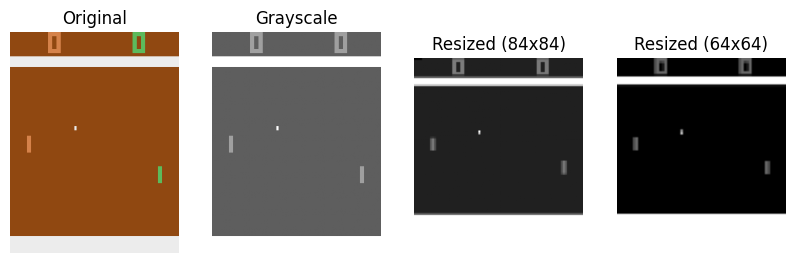

In [51]:
import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt

with h5py.File(file_path, 'r') as f:
    obs = f['observations'][40]

gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY) 
resized_obs = cv2.resize(gray_obs, (84, 84), interpolation=cv2.INTER_LINEAR)
small_resized_obs = cv2.resize(gray_obs, (64, 64), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(obs)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(gray_obs, cmap='gray')
plt.title("Grayscale")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(resized_obs, cmap='gray')
plt.title("Resized (84x84)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(small_resized_obs, cmap='gray')
plt.title("Resized (64x64)")
plt.axis('off')
plt.show()

## Results

- Preprocess (grayscale 84 x 84)
- Replay buffer to provide CNN a sense of motion and velocity